# Лабораторная работа №4

*Арешин Станислав Олегович М8О-211M-21*

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.
По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

%matplotlib inline

# Предобработка данных

In [2]:
df = pd.read_csv('real_estate_data.csv', sep='\t')
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


Булевы типы переведем в целые

In [3]:
df['studio'] = df['studio'].astype('int64')
df['open_plan'] = df['open_plan'].astype('int64')

## Пропущенные значения

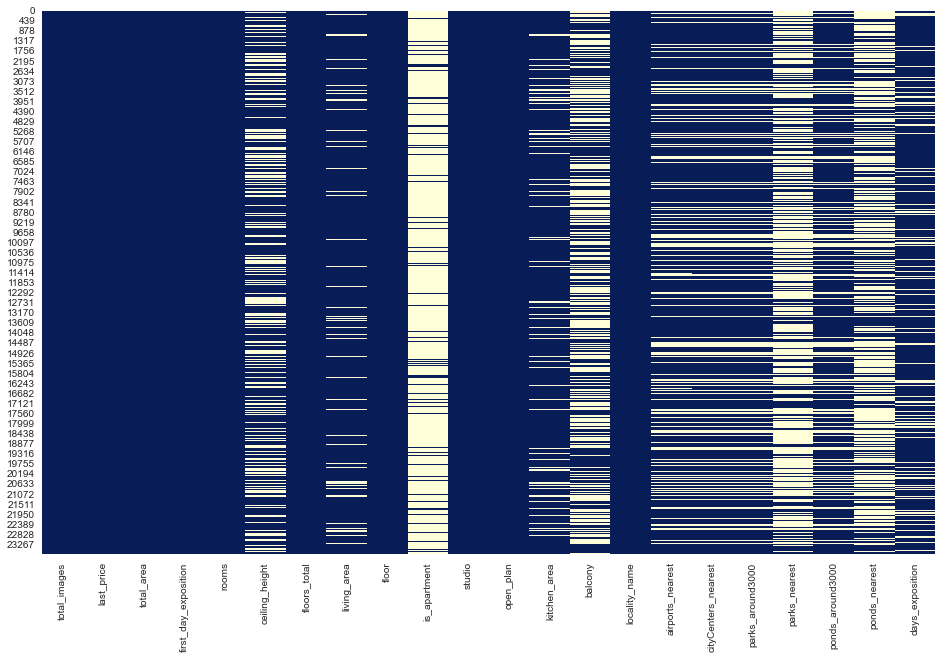

In [4]:
fig, ax = plt.subplots(figsize=(16,10))
sns.heatmap(df.isnull(), cbar=False, cmap="YlGnBu_r")
plt.show()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  int64  
 11  open_plan             23699 non-null  int64  
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Много пропущенных значений, давайте разибраться по порядку

### ceiling_height

In [6]:
df['ceiling_height'].min(), df['ceiling_height'].max()

(1.0, 100.0)

Значение признака - высота потолков (м). Минимальное значение 1м, максимально 100м. Это похоже на аномальные значения, поэтому я предлагаю клипнуть данные снизу 2.4 м. (минимальная норма, чуть ниже стандартного значения), сверху 4 м. (для совсем элитного жилья)

In [7]:
df['ceiling_height'] = df['ceiling_height'].clip(2.4, 4)

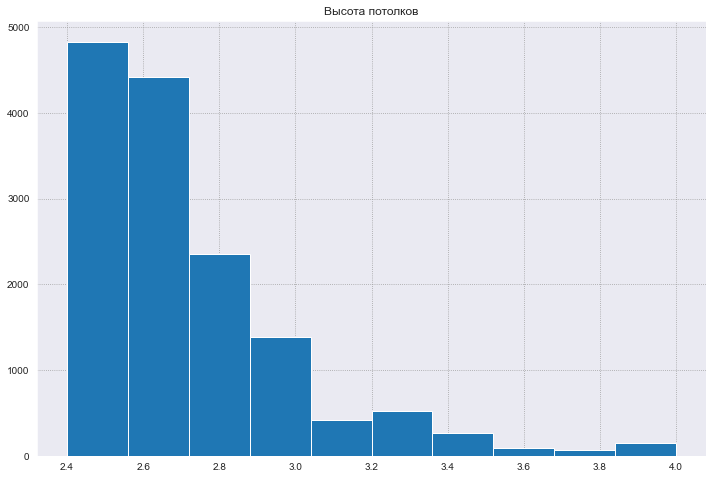

In [8]:
plt.figure(figsize=(12,8))
plt.title('Высота потолков')
plt.hist(df['ceiling_height'])
plt.show()

Распределение теперь ок, пропущенные значения заполним медианным, это кажется логичным 

In [9]:
df['ceiling_height'].median()

2.65

In [10]:
df['ceiling_height'] = df['ceiling_height'].fillna(df['ceiling_height'].median())

### living_area, kitchen_area
жилая площадь в квадратных метрах(м²), площадь кухни в квадратных метрах. При том что признак площадь квартиры полностью заполнен, можно предположить что если обе колонки не заполнены, то это студия (можно выделить как отдельный признак и сверить с имеющимся), если что-то одно не заполнено, то может просто забыли (?). Тогда если вместе living_area, kitchen_area пропущены - то бинарный признак is_studio, самое значение ставим -1. Если заполнено что-то одно, то вычитаем из общей площади имеющееся значение.

In [11]:
df[['living_area', 'kitchen_area']].isna().all(axis=1).apply(lambda x: 1 if x else 0).sum()

1464

In [12]:
df['is_studio'] = df[['living_area', 'kitchen_area']].isna().all(axis=1).apply(lambda x: 1 if x else 0)
df['living_area'] = df.apply(
                        lambda row: row['total_area'] - row['kitchen_area']
                        if np.isnan(row['living_area']) and ~np.isnan(row['kitchen_area'])
                        else row['living_area'], axis=1
                    )
df['kitchen_area'] = df.apply(
                        lambda row: row['total_area'] - row['living_area']
                        if np.isnan(row['kitchen_area']) and ~np.isnan(row['living_area'])
                        else row['kitchen_area'], axis=1
                    )
df['living_area'] = df['living_area'].fillna(-1)
df['kitchen_area'] = df['kitchen_area'].fillna(-1)

In [13]:
df[df['is_studio'] != df['studio']][['is_studio', 'studio']]

,is_studio,studio
3,1,0
30,1,0
37,1,0
44,1,0
59,1,0
...,...,...
23637,0,1
23642,1,0
23663,1,0
23670,1,0


Окей, предположение со студией не сработало, поэтому просто переименуем колонку в isna_area_divide

In [14]:
df.rename(columns={'is_studio': 'isna_area_divide'}, inplace=True)

### is_apartment 

Тут все просто, пропущенное значение, значит это поле не указали и логично, что тогда это не апартаменты. Ставим в пропущенные значения 

In [15]:
df['is_apartment'].unique()

array([nan, False, True], dtype=object)

In [16]:
df['is_apartment'] = df['is_apartment'].fillna(False)
df['is_apartment'] = df['is_apartment'].astype('int64')

In [17]:
df['is_apartment'].unique()

array([0, 1], dtype=int64)

### balcony
Логично, что отстутсвие балкона - пропуск. Заполняем 0

In [18]:
df['balcony'] = df['balcony'].fillna(0)

### Ближайшие точки

Такие признаки как airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest можно попробовать восстановить только более подробным исследованием, например пытаться найти ближайшего соседа и брать значения у него (у нас нет гео меток, но можно постараться сделать это по имеющимся заполненным точкам). Процесс долгий и сложный,  предлагаю заполнить пропущенные значения -1 и считать, что их просто забыли указать, либо ближайший парк, аэропорт и тд так далеко, что указывать было стыдно))

In [19]:
fill_list = ['airports_nearest', 'cityCenters_nearest', 'parks_around3000', 'parks_nearest', 'ponds_around3000', 'ponds_nearest']
df[fill_list] = df[fill_list].fillna(-1)

### floors_total 

Не так много пропущенных значений, предлагаю заполнить медианой

In [20]:
df['floors_total'].min(), df['floors_total'].max(), df['floors_total'].median(), df['floors_total'].mean()

(1.0, 60.0, 9.0, 10.67382374115953)

In [21]:
df['floors_total'] = df['floors_total'].fillna(df['floors_total'].median())

### locality_name

Заполним наиболее частым

In [24]:
from collections import Counter

Counter(df['locality_name']).most_common(1)[0][0]

'Санкт-Петербург'

In [25]:
df['locality_name'] = df['locality_name'].fillna('Санкт-Петербург')

### days_exposition 

сколько дней было размещено объявление (от публикации до снятия). Тоже не очень много нанов, проще всего заполнить медианой

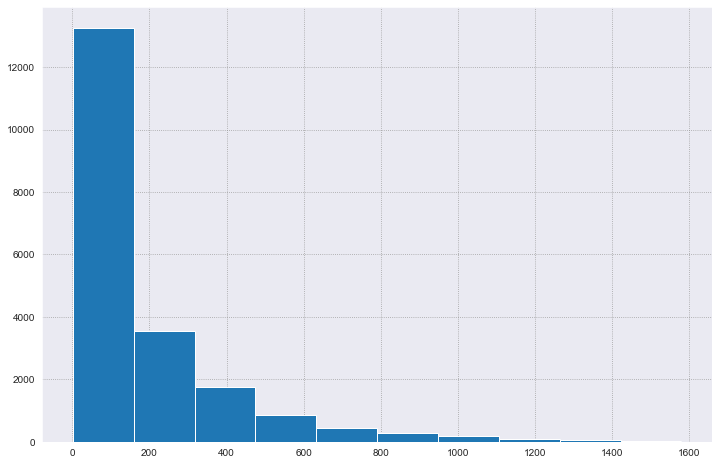

In [26]:
plt.figure(figsize=(12,8))
plt.hist(df['days_exposition'])
plt.show()

In [27]:
df['days_exposition'] = df['days_exposition'].fillna(df['days_exposition'].median())

## Публикация объявления: first_day_exposition

Из даты можно вытащить много полезной инфы как для аналитики, так и для построения модели в дальнейшем. С типом datetime напрямую довольно сложно работать. Сделаем это.

In [28]:
def get_datetime_features(df):
    df_res = df.copy()
    df_res['first_day_exposition'] = pd.to_datetime(df_res['first_day_exposition'])
    df_res['year'] = df_res['first_day_exposition'].dt.year
    df_res['month'] = df_res['first_day_exposition'].dt.month
    df_res['day'] = df_res['first_day_exposition'].dt.day
    df_res['weekday'] = df_res['first_day_exposition'].dt.weekday
    return df_res

In [29]:
df = get_datetime_features(df)
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,isna_area_divide,year,month,day,weekday
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.0,8,0,...,1.0,482.0,2.0,755.0,95.0,0,2019,3,7,3
1,7,3350000.0,40.4,2018-12-04,1,2.65,11.0,18.6,1,0,...,0.0,-1.0,0.0,-1.0,81.0,0,2018,12,4,1
2,10,5196000.0,56.0,2015-08-20,2,2.65,5.0,34.3,4,0,...,1.0,90.0,2.0,574.0,558.0,0,2015,8,20,3
3,0,64900000.0,159.0,2015-07-24,3,2.65,14.0,-1.0,9,0,...,2.0,84.0,3.0,234.0,424.0,1,2015,7,24,4
4,2,10000000.0,100.0,2018-06-19,2,3.03,14.0,32.0,13,0,...,2.0,112.0,1.0,48.0,121.0,0,2018,6,19,1


## Этажи

Найдем доп информацию по этажам: первый, последний, другой;

In [30]:
df['floor_type'] = df.apply(lambda row: 'Последний' if row['floors_total'] == row['floor']
                           else 'Другой', axis=1)
df['floor_type'] = df.apply(lambda row: 'Первый' if row['floor'] == 1 
                           else row['floor_type'], axis=1)
df['floor_type'].unique()

array(['Другой', 'Первый', 'Последний'], dtype=object)

## Цена квадратного метра

Вычислим цену квадратного метра

In [31]:
df['price_per_m2'] = df['last_price'] / df['total_area']

## Отношения

Соотношение жилой и общей площади, а также отношение площади кухни к общей. Помним, что мы заполняли пропущенные значения в площадях через -1, будет правильным и отношение в таком случае заполнить через -1 (как будто тоже пропуск)

In [32]:
df['living/total'] = df['living_area'] / df['total_area']
df['kitchen/total'] = df['kitchen_area'] / df['total_area']
df['living/total'] = df.apply(lambda row: -1 if row['living/total'] < 0 else row['living/total'], axis = 1)
df['kitchen/total'] = df.apply(lambda row: -1 if row['kitchen/total'] < 0 else row['kitchen/total'], axis = 1)

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 31 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        23699 non-null  float64       
 6   floors_total          23699 non-null  float64       
 7   living_area           23699 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-null  int64         
 10  studio                23699 non-null  int64         
 11  open_plan             23699 non-null  int64         
 12  kitchen_area          23699 non-null  float64       
 13  balcony         

# EDA

## Параметры квартир

### Площадь 

In [34]:
df['living_area'].min(), df['living_area'].max(), df['living_area'].median()

(-1.0, 571.0, 29.7)

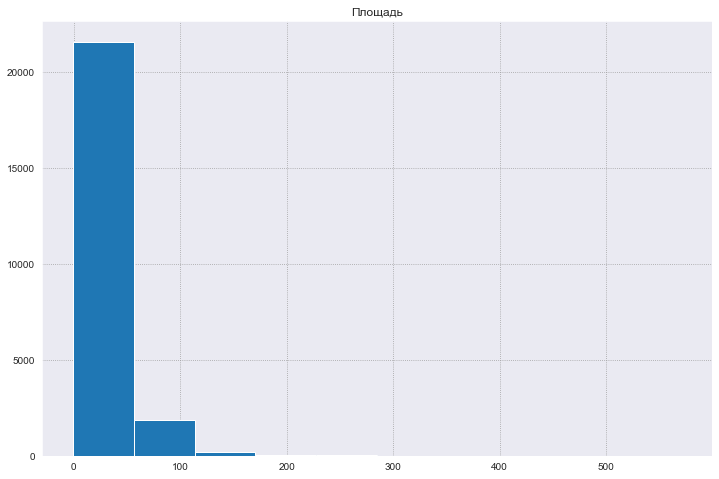

In [35]:
plt.figure(figsize=(12,8))
plt.title('Площадь')
plt.hist(df['living_area'])
plt.show()

В площади обнаружились пропущенные значения, заполненные не мной (-1). Также максимальное значение 571 (что это за дворец). Может не пропустили точку (например 57.1), либо мошенническое объявление. Предлагаю клипнуть сверху в 100 кв. метров, все, где будет 100 - очень большие квартиры и нам этого достаточно 

In [36]:
df['living_area'] = df['living_area'].clip(-1, 100)

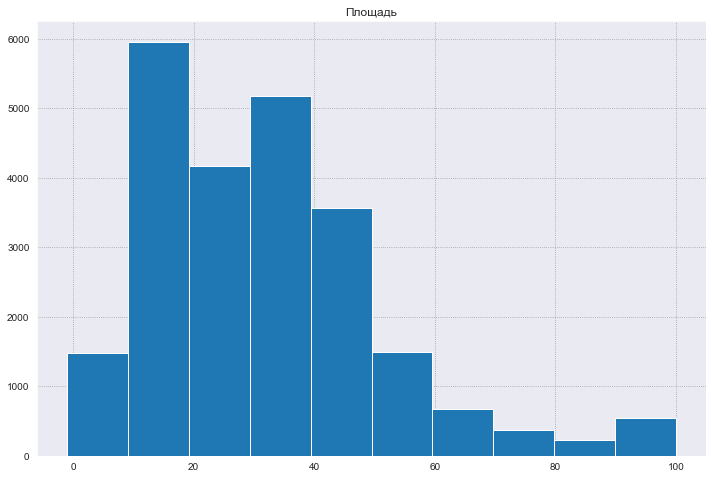

In [37]:
plt.figure(figsize=(12,8))
plt.title('Площадь')
plt.hist(df['living_area'])
plt.show()

Теперь распределение больше похоже на правду, обычно продают более менее стандартные квартиры, медиана 29.7 - это просторная однушка

### Высота потолков

Исследовал в самом начале, там тоже клипнул аномальные значения. Кроме них ничего особенного, большинство квартир со стандартными потолками, есть с высокими - элитное жилье или сталинки.

### Количество комнат 

In [38]:
df['rooms'].min(), df['rooms'].max(), df['rooms'].median()

(0, 19, 2.0)

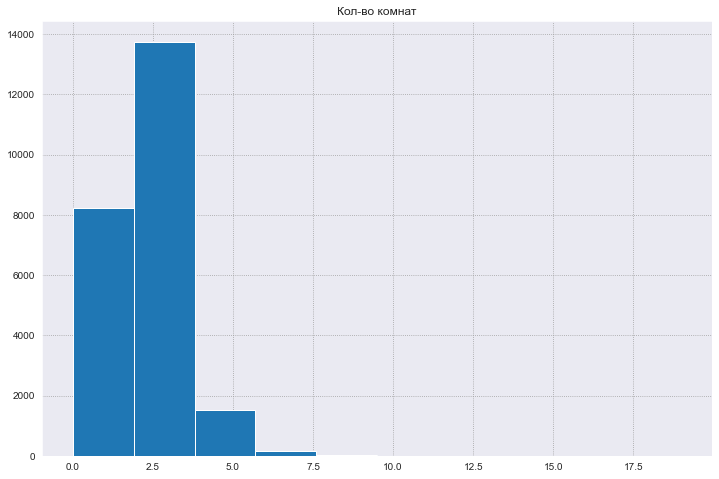

In [39]:
plt.figure(figsize=(12,8))
plt.title('Кол-во комнат')
plt.hist(df['rooms'])
plt.show()

19 комнат это что-то странное, как будто продают целый этаж, либо особняк. Медиана - двушка, если стыковать с медианой площади, то значит двушки довольно маленьке, либо попадают под термин "евродвушка" - однокомнатная квартира с просторной кухней (как доп комната). 0 комнат - скорее всего пропущенные значения, либо студия, давайте посмотрим

In [40]:
len(df[df['rooms'] == 0]), df[df['rooms'] == 0]['studio'].sum()

(197, 138)

Да, по большей части так указывают студии (это странно), остальное просто видно не заполнили

### Цена

In [41]:
df['last_price'].min(), df['last_price'].max(), df['last_price'].median()

(12190.0, 763000000.0, 4650000.0)

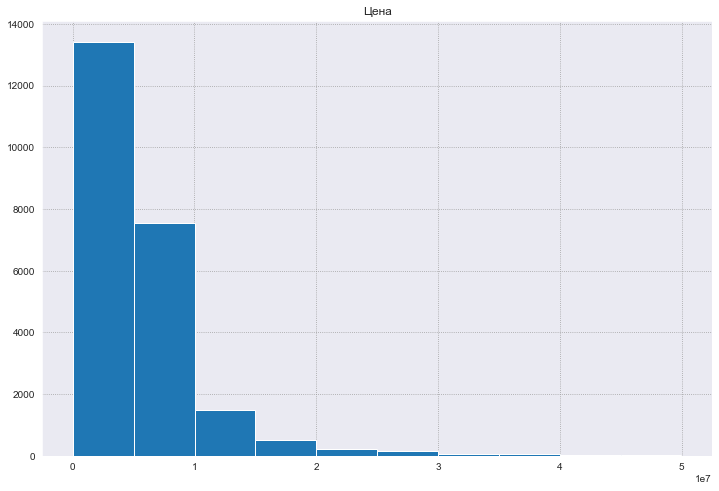

In [42]:
plt.figure(figsize=(12,8))
plt.title('Цена')
plt.hist(df[df['last_price'] < 0.5e8]['last_price'])
plt.show()

Цена - показатель, в котором вряд ли могли ошибится при заполнении, значит в нем править ничего не будем. Минимальная цена - 12к, может случайно в данные попала аренда комнаты. Максимальная 763 млн. не представляю, что может столько стоить. Большая часть квартир с нормальной стоимостью до 10 млн. Медиана 4 млн. 650 тыс., что тоже ок для Санкт-Петербурга и окрестностей.

## Время продажи квартиры

График уже строили ранее, но построим еще раз

In [43]:
df['days_exposition'].min(), df['days_exposition'].max(), df['days_exposition'].median(), df['days_exposition'].mean()

(1.0, 1580.0, 95.0, 169.36022616988058)

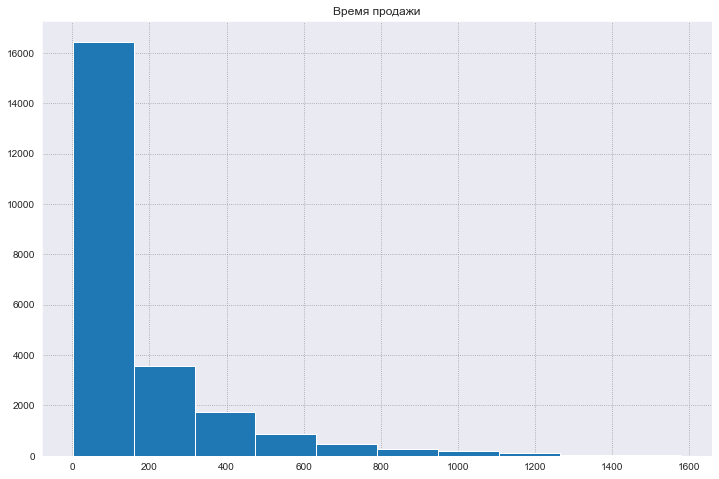

In [44]:
plt.figure(figsize=(12,8))
plt.title('Время продажи')
plt.hist(df['days_exposition'])
plt.show()

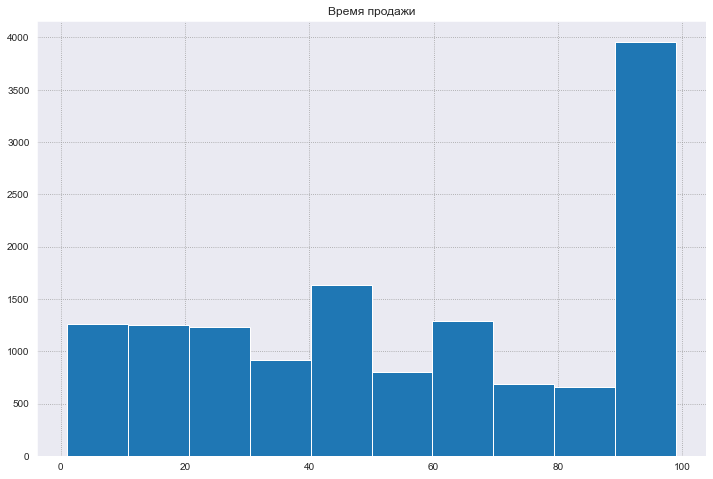

In [45]:
plt.figure(figsize=(12,8))
plt.title('Время продажи')
plt.hist(df[df['days_exposition'] < 100]['days_exposition'])
plt.show()

Нормальным временем продажи можно считать медиану - 95 дней (ну округлим до 100) Это чуть больше трех месяцев. Слишком быстрой продажей можно считать все, что меньше месяца или полутора месяцев, я бы остановился на первом варианте. Максимально объявление висело больше 4 лет. Значит не очень и нужно было продавать, либо это объявление - ошибка или прикол, о котором все забыли. Долгой продажей я бы считал от 9 месяцев, примерно 270 дней. По графику видно, что к этому моменту бОльшая часть объявлений снимается.

## От чего зависит цена?

In [46]:
from scipy.stats import spearmanr, pearsonr

### Цена и площадь

In [47]:
# монотонная зависимость
corr, p = spearmanr(df['total_area'], df['last_price'])

print(f'p_value = {p} ->')
if p < 0.05:
    print('Отвергаем гипотезу H0: нет зависимости между переменными')
    print(f'Коэффициент корреляции r = {corr}')
else:
    print('Не можем отвергнуть H0: нет зависимости между переменными')

p_value = 0.0 ->
Отвергаем гипотезу H0: нет зависимости между переменными
Коэффициент корреляции r = 0.7483494842427628


In [48]:
# линейная
corr, p = pearsonr(df['total_area'], df['last_price'])

print(f'p_value = {p} ->')
if p < 0.05:
    print('Отвергаем гипотезу H0: нет зависимости между переменными')
    print(f'Коэффициент корреляции r = {corr}')
else:
    print('Не можем отвергнуть H0: нет зависимости между переменными')

p_value = 0.0 ->
Отвергаем гипотезу H0: нет зависимости между переменными
Коэффициент корреляции r = 0.653675057965724


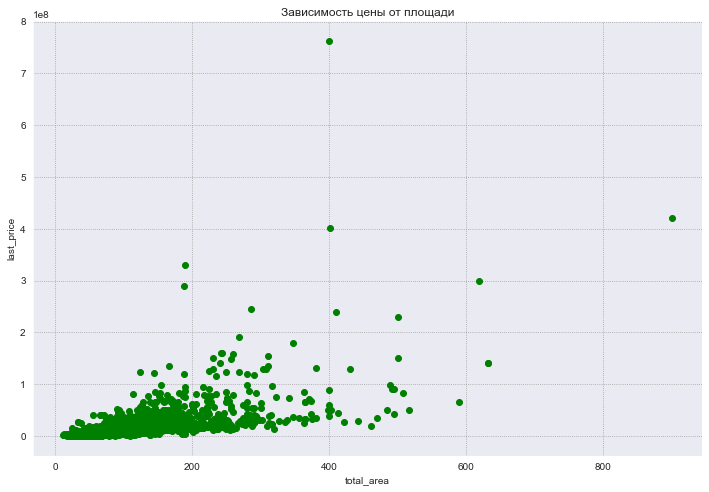

In [49]:
plt.figure(figsize=(12,8))
plt.title('Зависимость цены от площади')
plt.scatter(df['total_area'], df['last_price'], c='green')
plt.xlabel('total_area')
plt.ylabel('last_price')
plt.show()

Цена и площадь зависят линейно и монотонно с довольно большими коэффициентами корреляции. Также эту зависимость отчетливо видно на графике. Это логично

### Цена и число комнат

In [50]:
# монотонная зависимость
corr, p = spearmanr(df['rooms'], df['last_price'])

print(f'p_value = {p} ->')
if p < 0.05:
    print('Отвергаем гипотезу H0: нет зависимости между переменными')
    print(f'Коэффициент корреляции r = {corr}')
else:
    print('Не можем отвергнуть H0: нет зависимости между переменными')

p_value = 0.0 ->
Отвергаем гипотезу H0: нет зависимости между переменными
Коэффициент корреляции r = 0.5392561470661834


In [51]:
# линейная
corr, p = pearsonr(df['rooms'], df['last_price'])

print(f'p_value = {p} ->')
if p < 0.05:
    print('Отвергаем гипотезу H0: нет зависимости между переменными')
    print(f'Коэффициент корреляции r = {corr}')
else:
    print('Не можем отвергнуть H0: нет зависимости между переменными')

p_value = 0.0 ->
Отвергаем гипотезу H0: нет зависимости между переменными
Коэффициент корреляции r = 0.3633428499648955


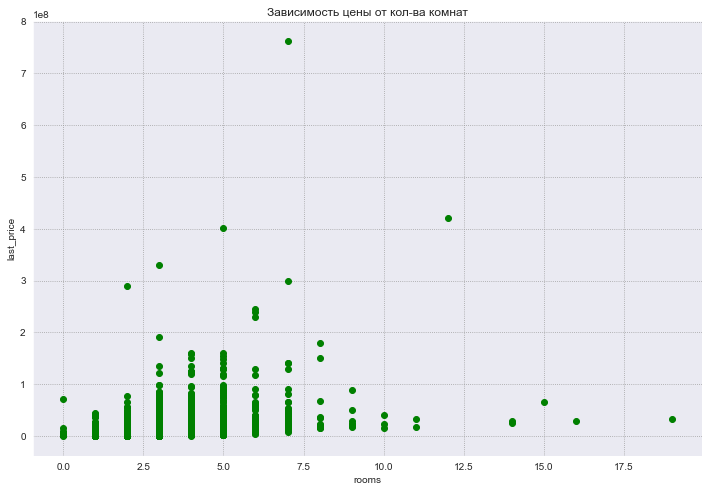

In [52]:
plt.figure(figsize=(12,8))
plt.title('Зависимость цены от кол-ва комнат')
plt.scatter(df['rooms'], df['last_price'], c='green')
plt.xlabel('rooms')
plt.ylabel('last_price')
plt.show()

Цена и кол-во комнат также зависят линейно и монотонно. На графике визуально это чуть чуть портится выбросами, однако зависимость видна и коэффициенты это доказывают

### Цена и удаленность от центра

In [53]:
# монотонная зависимость
corr, p = spearmanr(df['cityCenters_nearest'], df['last_price'])

print(f'p_value = {p} ->')
if p < 0.05:
    print('Отвергаем гипотезу H0: нет зависимости между переменными')
    print(f'Коэффициент корреляции r = {corr}')
else:
    print('Не можем отвергнуть H0: нет зависимости между переменными')

p_value = 8.063299664046264e-132 ->
Отвергаем гипотезу H0: нет зависимости между переменными
Коэффициент корреляции r = 0.1577123065721335


In [54]:
# линейная
corr, p = pearsonr(df['cityCenters_nearest'], df['last_price'])

print(f'p_value = {p} ->')
if p < 0.05:
    print('Отвергаем гипотезу H0: нет зависимости между переменными')
    print(f'Коэффициент корреляции r = {corr}')
else:
    print('Не можем отвергнуть H0: нет зависимости между переменными')

p_value = 4.211157847253028e-15 ->
Отвергаем гипотезу H0: нет зависимости между переменными
Коэффициент корреляции r = -0.05095199334276185


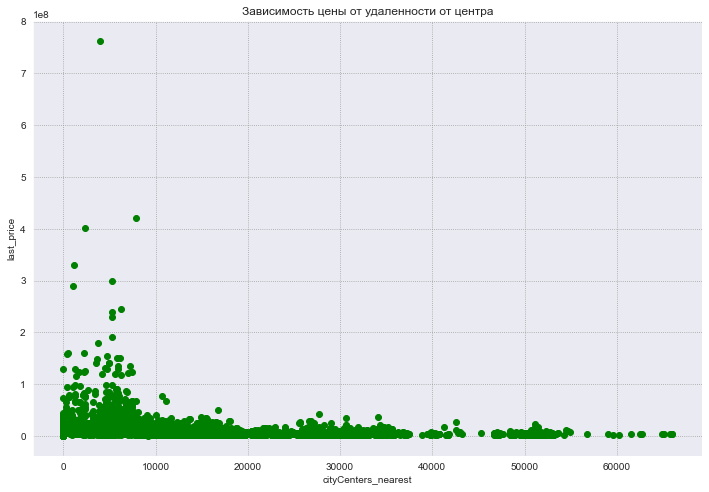

In [55]:
plt.figure(figsize=(12,8))
plt.title('Зависимость цены от удаленности от центра')
plt.scatter(df['cityCenters_nearest'], df['last_price'], c='green')
plt.xlabel('cityCenters_nearest')
plt.ylabel('last_price')
plt.show()

Обратная линейная монотонная зависимость. Чем дальше от центра - тем дешевле. Очень логично. Коэффициенты небольшие, но на графике зависимость отчетливо прослеживается.

### Цена и тип этажа

Тут сложно установить порядок приоритета этажей. Обычно люди не очень хотят жить на первом (шумно, плюс могут ограбить) это будет кодировка 1, чуть меньше жить на последнем (а вдруг крыша потечет) это будет 2, а Другой пусть будет 3

In [56]:
# монотонная зависимость
corr, p = spearmanr(df['floor_type'].map({'Первый' : 1, 'Последний' : 2, 'Другой' : 3}), df['last_price'])

print(f'p_value = {p} ->')
if p < 0.05:
    print('Отвергаем гипотезу H0: нет зависимости между переменными')
    print(f'Коэффициент корреляции r = {corr}')
else:
    print('Не можем отвергнуть H0: нет зависимости между переменными')

p_value = 1.5457721232004723e-126 ->
Отвергаем гипотезу H0: нет зависимости между переменными
Коэффициент корреляции r = 0.15450978397361212


In [57]:
# линейная
corr, p = pearsonr(df['floor_type'].map({'Первый' : 1, 'Последний' : 2, 'Другой' : 3}), df['last_price'])

print(f'p_value = {p} ->')
if p < 0.05:
    print('Отвергаем гипотезу H0: нет зависимости между переменными')
    print(f'Коэффициент корреляции r = {corr}')
else:
    print('Не можем отвергнуть H0: нет зависимости между переменными')

p_value = 1.9369811086813892e-10 ->
Отвергаем гипотезу H0: нет зависимости между переменными
Коэффициент корреляции r = 0.04133865283953157


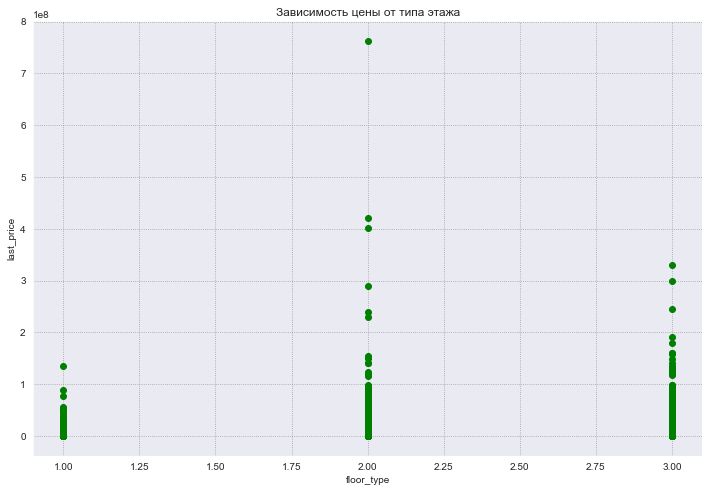

In [58]:
plt.figure(figsize=(12,8))
plt.title('Зависимость цены от типа этажа')
plt.scatter(df['floor_type'].map({'Первый' : 1, 'Последний' : 2, 'Другой' : 3}), df['last_price'], c='green')
plt.xlabel('floor_type')
plt.ylabel('last_price')
plt.show()

С учетом установленного порядка ранжирования предпочтения типа этажа видна линейная монотонная зависимость. Однако, если порядок поменять по-другому, ее можно разрушить. Все зависит от анализа предпочтений покупателей.

### Цена и день недели

In [59]:
# монотонная зависимость
corr, p = spearmanr(df['weekday'], df['last_price'])

print(f'p_value = {p} ->')
if p < 0.05:
    print('Отвергаем гипотезу H0: нет зависимости между переменными')
    print(f'Коэффициент корреляции r = {corr}')
else:
    print('Не можем отвергнуть H0: нет зависимости между переменными')

p_value = 0.017671143497040267 ->
Отвергаем гипотезу H0: нет зависимости между переменными
Коэффициент корреляции r = -0.015410861729399459


In [60]:
# линейная
corr, p = pearsonr(df['weekday'], df['last_price'])

print(f'p_value = {p} ->')
if p < 0.05:
    print('Отвергаем гипотезу H0: нет зависимости между переменными')
    print(f'Коэффициент корреляции r = {corr}')
else:
    print('Не можем отвергнуть H0: нет зависимости между переменными')

p_value = 0.8113968862535765 ->
Не можем отвергнуть H0: нет зависимости между переменными


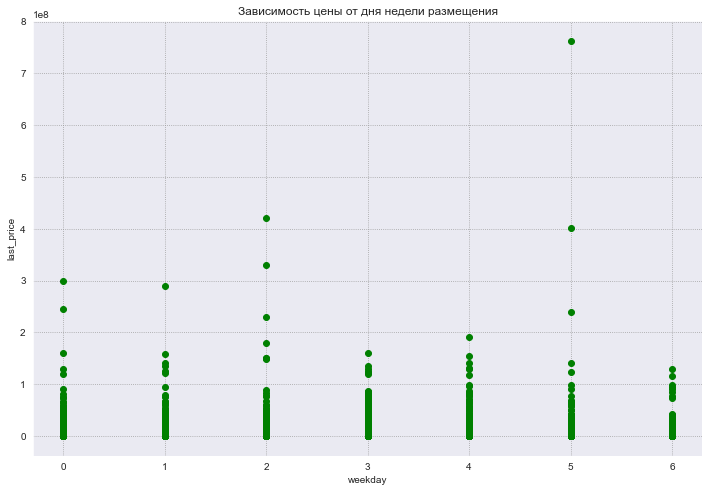

In [61]:
plt.figure(figsize=(12,8))
plt.title('Зависимость цены от дня недели размещения')
plt.scatter(df['weekday'], df['last_price'], c='green')
plt.xlabel('weekday')
plt.ylabel('last_price')
plt.show()

Тест говорит о наличии монотонной зависимости с отрицательным коэффициентом. На графике она плохо отслеживается, но если визуально исключить выбросы - она видна.

### Цена и месяц

In [62]:
# монотонная зависимость
corr, p = spearmanr(df['month'], df['last_price'])

print(f'p_value = {p} ->')
if p < 0.05:
    print('Отвергаем гипотезу H0: нет зависимости между переменными')
    print(f'Коэффициент корреляции r = {corr}')
else:
    print('Не можем отвергнуть H0: нет зависимости между переменными')

p_value = 0.6752775651528751 ->
Не можем отвергнуть H0: нет зависимости между переменными


In [63]:
# линейная
corr, p = pearsonr(df['month'], df['last_price'])

print(f'p_value = {p} ->')
if p < 0.05:
    print('Отвергаем гипотезу H0: нет зависимости между переменными')
    print(f'Коэффициент корреляции r = {corr}')
else:
    print('Не можем отвергнуть H0: нет зависимости между переменными')

p_value = 0.6687889707310194 ->
Не можем отвергнуть H0: нет зависимости между переменными


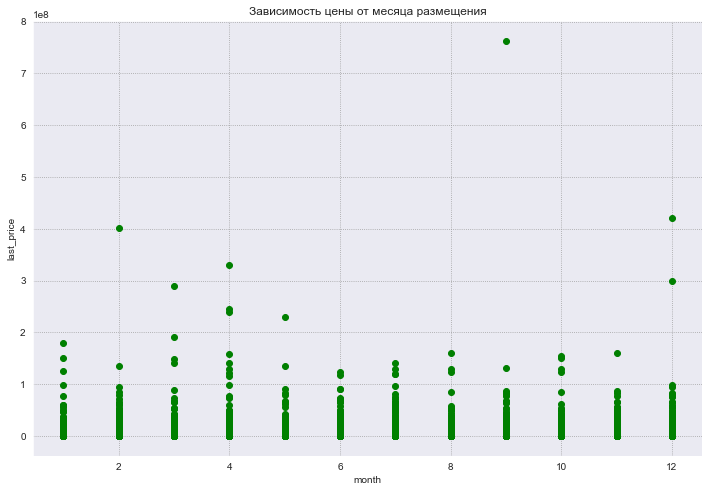

In [64]:
plt.figure(figsize=(12,8))
plt.title('Зависимость цены от месяца размещения')
plt.scatter(df['month'], df['last_price'], c='green')
plt.xlabel('month')
plt.ylabel('last_price')
plt.show()

Нет зависимостей

### Цена и год

In [65]:
# монотонная зависимость
corr, p = spearmanr(df['year'], df['last_price'])

print(f'p_value = {p} ->')
if p < 0.05:
    print('Отвергаем гипотезу H0: нет зависимости между переменными')
    print(f'Коэффициент корреляции r = {corr}')
else:
    print('Не можем отвергнуть H0: нет зависимости между переменными')

p_value = 0.3346806317951082 ->
Не можем отвергнуть H0: нет зависимости между переменными


In [66]:
# линейная
corr, p = pearsonr(df['year'], df['last_price'])

print(f'p_value = {p} ->')
if p < 0.05:
    print('Отвергаем гипотезу H0: нет зависимости между переменными')
    print(f'Коэффициент корреляции r = {corr}')
else:
    print('Не можем отвергнуть H0: нет зависимости между переменными')

p_value = 3.2216805249482084e-11 ->
Отвергаем гипотезу H0: нет зависимости между переменными
Коэффициент корреляции r = -0.04308903619950847


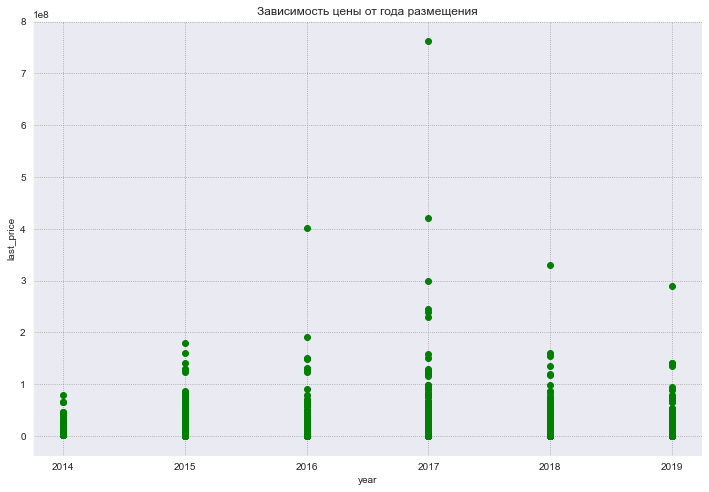

In [67]:
plt.figure(figsize=(12,8))
plt.title('Зависимость цены от года размещения')
plt.scatter(df['year'], df['last_price'], c='green')
plt.xlabel('year')
plt.ylabel('last_price')
plt.show()

Видно линейную зависимость

## Самые частые населенные пункты

Выберем 10 населённых пунктов с наибольшим числом объявлений. Посчитаем среднюю цену квадратного метра в этих населённых пунктах. Выделим среди них населённые пункты с самой высокой и низкой стоимостью жилья

In [71]:
from collections import Counter

most_popular = [el[0] for el in Counter(df['locality_name']).most_common(10)]
most_popular

['Санкт-Петербург',
 'посёлок Мурино',
 'посёлок Шушары',
 'Всеволожск',
 'Пушкин',
 'Колпино',
 'посёлок Парголово',
 'Гатчина',
 'деревня Кудрово',
 'Выборг']

In [72]:
df_tmp = df[df['locality_name'].isin(most_popular)].copy()
df_tmp.shape

(19007, 31)

In [73]:
df_tmp.groupby('locality_name').mean()[['price_per_m2']].reset_index().sort_values('price_per_m2', ascending=False)

,locality_name,price_per_m2
5,Санкт-Петербург,114785.190679
4,Пушкин,103125.819291
6,деревня Кудрово,92473.547576
8,посёлок Парголово,90175.913458
7,посёлок Мурино,85752.189195
9,посёлок Шушары,78677.364217
3,Колпино,75424.579098
2,Гатчина,68746.146763
0,Всеволожск,68654.473986
1,Выборг,58141.909153


Ожидаемо, что самая большая цена за средний квадратный метр в СПБ, далее пригороды. Мурино, Кудрово, Шушары и т.д. цена постепенно падает - это районы с большим кол-вом новостроек. Самая низкая цена из популярных в Выборге (это действительно очень далеко).

## Центр СПБ

### Определяем сегмент центра

Посчитаем расстояние в км от центра и среднюю цену за кв. метр на каждом километре. Должно стать понятно, какая область считается центром

In [74]:
df_tmp = df[df['locality_name'] == 'Санкт-Петербург'].copy()
df_tmp.shape

(15770, 31)

In [75]:
df_tmp['to_centr_km'] = np.round(df_tmp['cityCenters_nearest'] / 1000)

In [76]:
df_tmp_avg = df_tmp.groupby('to_centr_km').mean()[['price_per_m2']].reset_index().sort_values('to_centr_km')

In [77]:
df_tmp_avg.head()

,to_centr_km,price_per_m2
0,-0.0,173862.269735
1,1.0,176640.649827
2,2.0,157944.348141
3,3.0,121299.669876
4,4.0,133035.838239


In [78]:
uniq = df_tmp['to_centr_km'].unique()

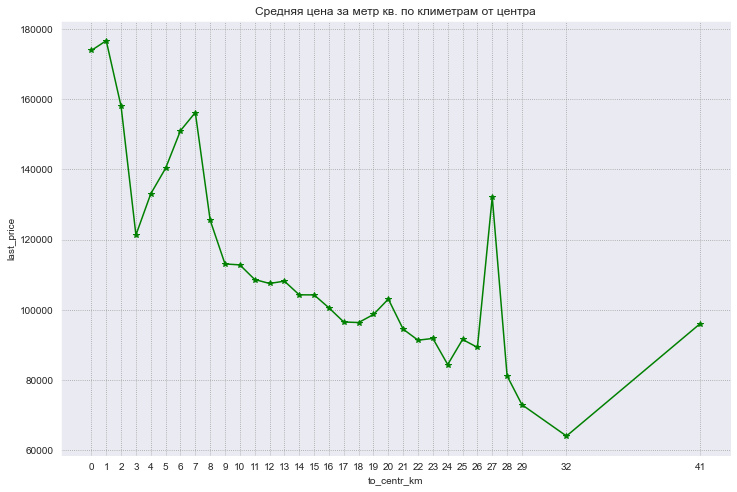

In [79]:
plt.figure(figsize=(12,8))
plt.title('Средняя цена за метр кв. по климетрам от центра')
plt.plot(df_tmp_avg['to_centr_km'], df_tmp_avg['price_per_m2'], c='green', marker='*')
plt.xlabel('to_centr_km')
plt.xticks(uniq)
plt.ylabel('last_price')
plt.show()

Кажется, что перепад на 7 км. Есть еще перепад на 3 км, но это похоже на выброс (среднее могло утянуться), так как потом цена опять растет. Построим еще один график зависимости центы от расстояния до центра в км.

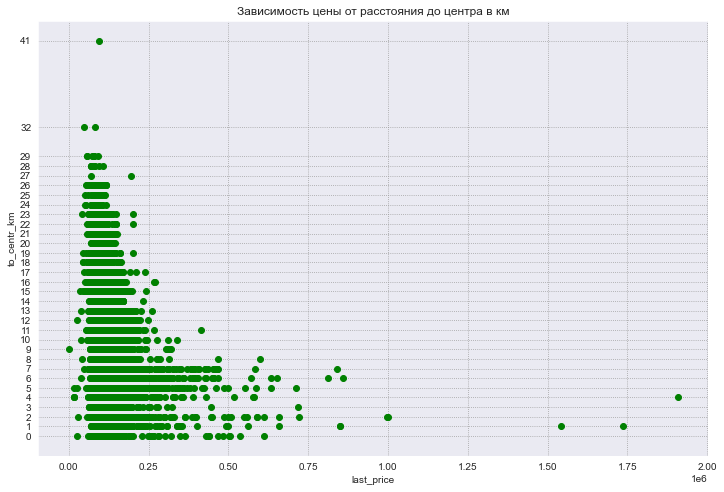

In [80]:
plt.figure(figsize=(12,8))
plt.title('Зависимость цены от расстояния до центра в км')
plt.scatter(df_tmp['price_per_m2'], df_tmp['to_centr_km'], c='green')
plt.ylabel('to_centr_km')
plt.yticks(uniq)
plt.xlabel('last_price')
plt.show()

На этот графике также перепад при 7 км. Пусть все что входит в радиус 7км - это центр Санкт-Петербурга. Выделим этот сегмент

In [81]:
df_tmp = df_tmp[df_tmp['to_centr_km'] <= 7]
df_tmp.shape

(3610, 32)

### Распределения в центре СПБ

In [82]:
df_tmp['living_area'].min(), df_tmp['living_area'].max(), df_tmp['living_area'].median()

(-1.0, 100.0, 44.0)

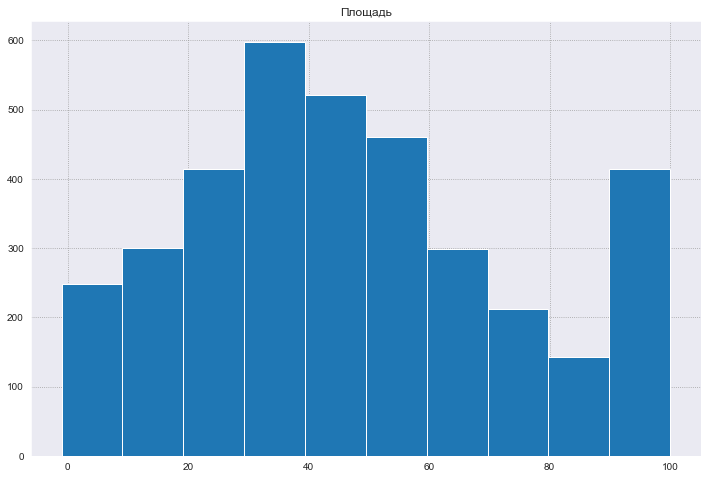

In [83]:
plt.figure(figsize=(12,8))
plt.title('Площадь')
plt.hist(df_tmp['living_area'])
plt.show()

В центре СПБ продают квартиры с бОльшей площадью, медиана 44 - это просторная двушка или небольшая трешка. Также гораздо больше крупных квартир, чем целом.

In [84]:
df_tmp['ceiling_height'].min(), df_tmp['ceiling_height'].max(), df_tmp['ceiling_height'].median()

(2.4, 4.0, 2.8)

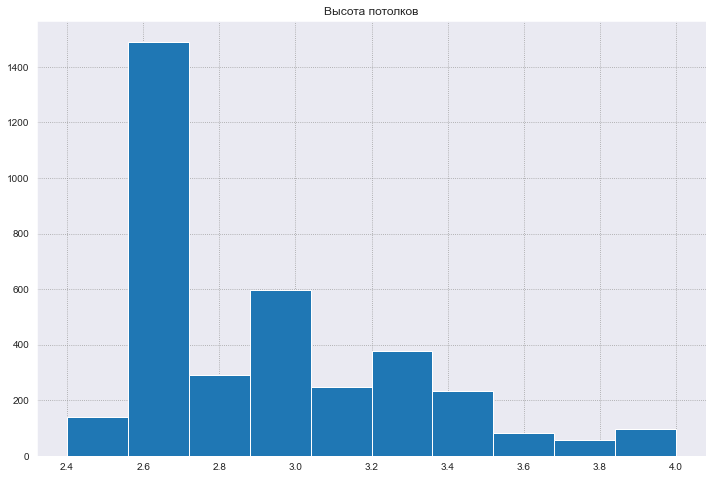

In [85]:
plt.figure(figsize=(12,8))
plt.title('Высота потолков')
plt.hist(df_tmp['ceiling_height'])
plt.show()

Казалось бы в центре СПБ должны быть квартиры с высокими потолками, но распределения отличаются не сильно 

In [86]:
df_tmp['rooms'].min(), df_tmp['rooms'].max(), df_tmp['rooms'].median()

(0, 19, 3.0)

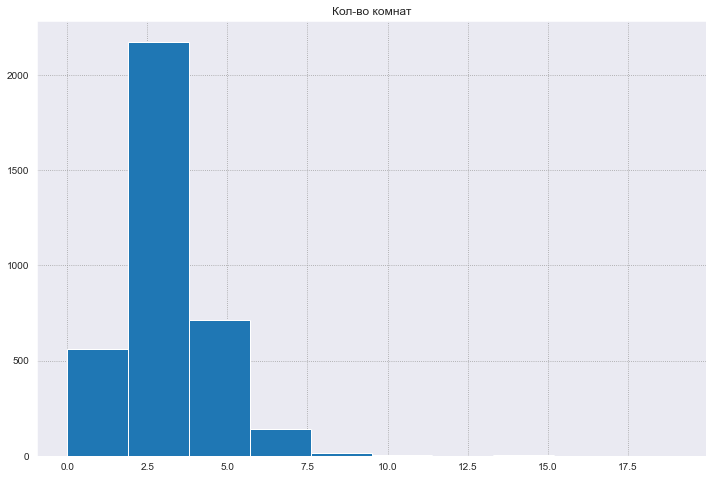

In [87]:
plt.figure(figsize=(12,8))
plt.title('Кол-во комнат')
plt.hist(df_tmp['rooms'])
plt.show()

Чаще всего продают трешки, опять же совпадает с медианой площади по центру СПБ, но отличается от картины в целом

In [88]:
df_tmp['last_price'].min(), df_tmp['last_price'].max(), df_tmp['last_price'].median()

(1600000.0, 763000000.0, 9195000.0)

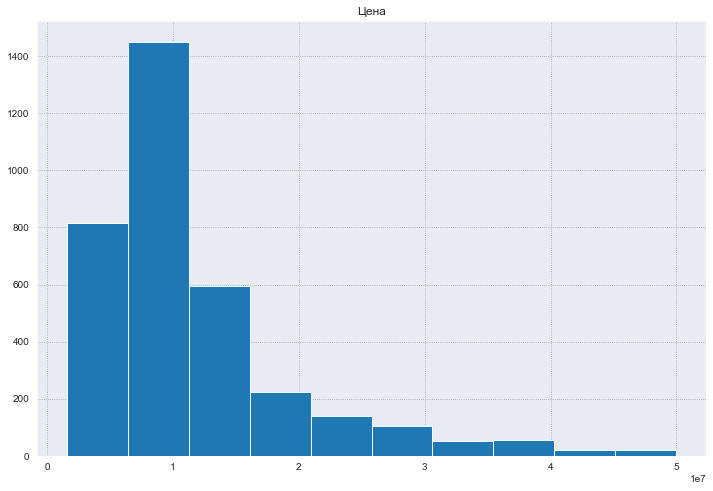

In [89]:
plt.figure(figsize=(12,8))
plt.title('Цена')
plt.hist(df_tmp[df_tmp['last_price'] < 0.5e8]['last_price'])
plt.show()

Как раз в центр СПБ попала самая дорогая квартира, медианная цена в два раза больше чем в общем. По графику видно, что квартиры гораздо дороже, что ожидаемо.

### Зависимости в центре СПБ

Я не буду заново проводить все стат тесты, уже есть предварительные результаты и образцы графиков. Давайте построим такие же графики и сравним их

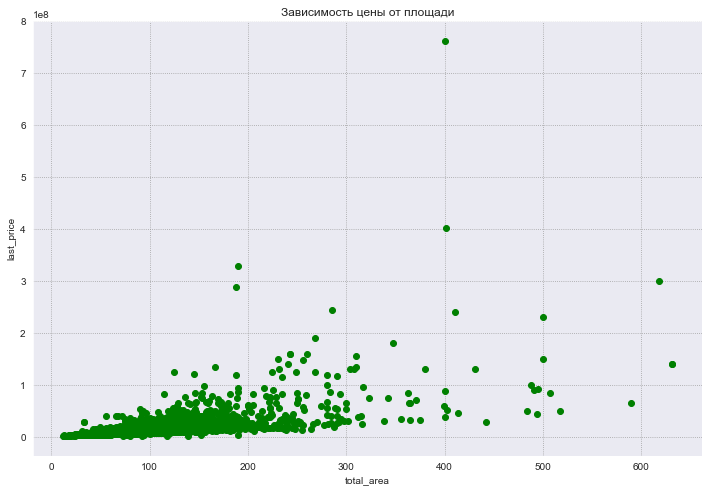

In [90]:
plt.figure(figsize=(12,8))
plt.title('Зависимость цены от площади')
plt.scatter(df_tmp['total_area'], df_tmp['last_price'], c='green')
plt.xlabel('total_area')
plt.ylabel('last_price')
plt.show()

Зависимость цены от площади сохраняется

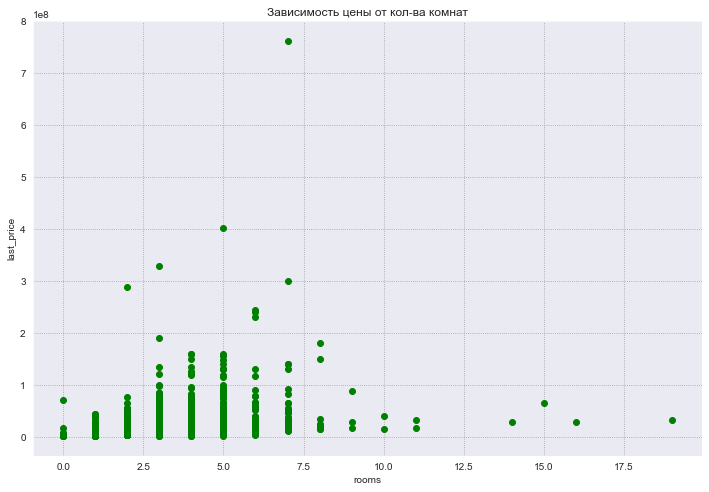

In [91]:
plt.figure(figsize=(12,8))
plt.title('Зависимость цены от кол-ва комнат')
plt.scatter(df_tmp['rooms'], df_tmp['last_price'], c='green')
plt.xlabel('rooms')
plt.ylabel('last_price')
plt.show()

Зависимость от кол-ва комнат сохраняется

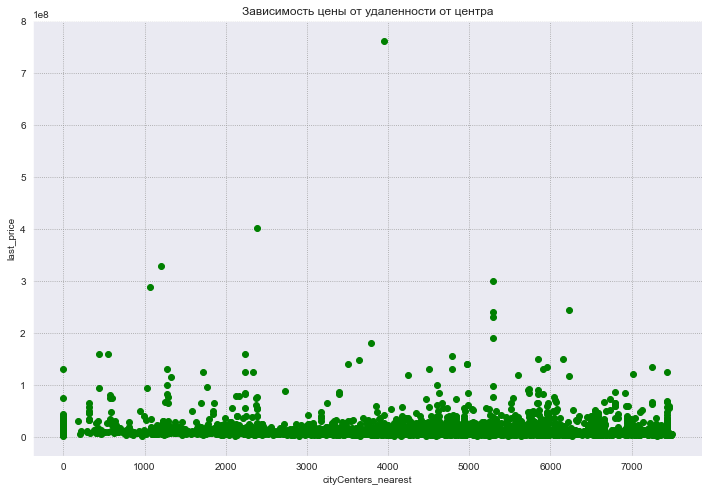

In [92]:
plt.figure(figsize=(12,8))
plt.title('Зависимость цены от удаленности от центра')
plt.scatter(df_tmp['cityCenters_nearest'], df_tmp['last_price'], c='green')
plt.xlabel('cityCenters_nearest')
plt.ylabel('last_price')
plt.show()

А вот зависимости от расстояния до центра больше нет. Объяснить можно тем, что мы и так берем центр и похоже в его рамках разброса сильного по километражу нет (мы ранее видели это на графиках)

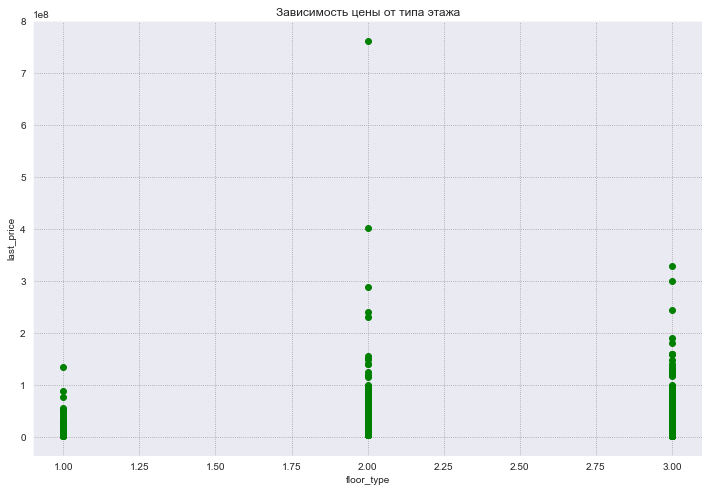

In [93]:
plt.figure(figsize=(12,8))
plt.title('Зависимость цены от типа этажа')
plt.scatter(df_tmp['floor_type'].map({'Первый' : 1, 'Последний' : 2, 'Другой' : 3}), df_tmp['last_price'], c='green')
plt.xlabel('floor_type')
plt.ylabel('last_price')
plt.show()

Зависимость сохраняется

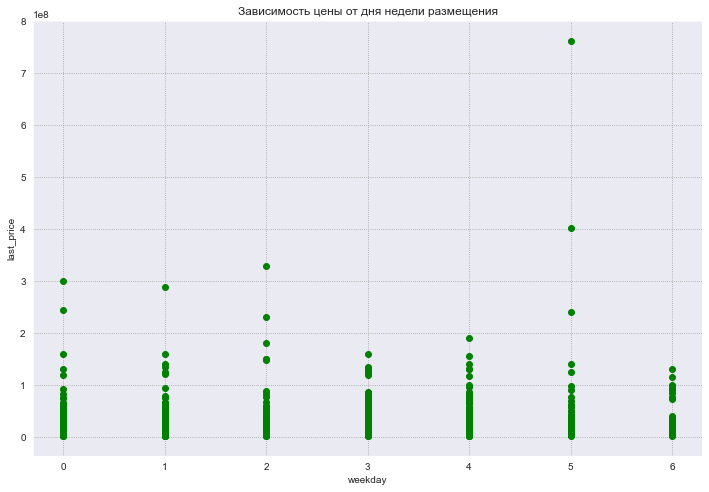

In [94]:
plt.figure(figsize=(12,8))
plt.title('Зависимость цены от дня недели размещения')
plt.scatter(df_tmp['weekday'], df_tmp['last_price'], c='green')
plt.xlabel('weekday')
plt.ylabel('last_price')
plt.show()

Похоже на такую же монотонную зависимость

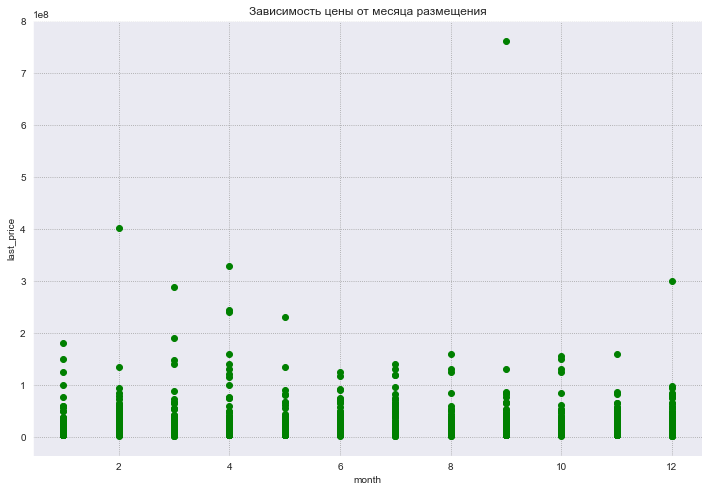

In [95]:
plt.figure(figsize=(12,8))
plt.title('Зависимость цены от месяца размещения')
plt.scatter(df_tmp['month'], df_tmp['last_price'], c='green')
plt.xlabel('month')
plt.ylabel('last_price')
plt.show()

Также зависимости нет

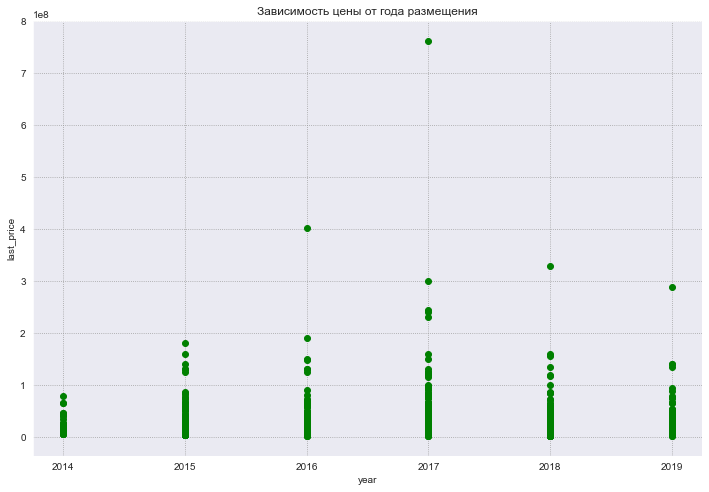

In [96]:
plt.figure(figsize=(12,8))
plt.title('Зависимость цены от года размещения')
plt.scatter(df_tmp['year'], df_tmp['last_price'], c='green')
plt.xlabel('year')
plt.ylabel('last_price')
plt.show()

Также линейная зависимость

# Выводы

В целом все выводы писал по ходу работы, кратко резюмирую

* Довольно интересные данные, требуют особой предобработки, которую можно еще улучшать и улучшать 
* Есть вполне логичные сильные линейные зависимости, например цена от площади или цена от расстояния до центра. Это означает, что с задачей прогноза должна неплохо справиться даже линейная модель.
* Ожидаемо самые дорогие квартиры в СПБ, особенно в центре. Если не брать ценрт, то много квартир в пригороде с новостройками, где как раз преобладают квартиры однокомнатные и двухкомнатные, что объясняет разницу в метраже квартир центра СПБ и общих данных. Аналогично можно сказать и о цене. Очевидно дорога из пригорода, плюс высокая новостройка - меньше цена, чем в черте города и в его центре.
* Зависимости в центре сохраняются почти такие же, как и на общих данных
* В данных все еще остались аномальности и выбросы, не все удалось почистить, но более глубокого погрузившись в область, подробнее исследовав странные значения, можно было бы сделать дополнительные выводы об их происхождении.